## Notebook for playing around with the Arlpy package

### Function to split stereo .wav into individual arrays

In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import wave
import IPython
import arlpy
import control
import pyroomacoustics as pra
from shlnb.shlnb import *

In [26]:
signal = wave.open("2kHz5sStereo.wav") # Synthetically produced PDM stereo by time-shifting in audacity by 0.001s emulating inter-microphone distance of ~30cm 
s_rate = signal.getframerate() # Sampling rate (Hz)
n_frames = signal.getnframes() # Total number of frames in audio file
n_channels = signal.getnchannels() # Number of channels in audio file
print("Sampling rate is:", s_rate)
print("Number of frames in audio file:", n_frames)
print("Number of channels in audio file:", n_channels)

Sampling rate is: 44100
Number of frames in audio file: 220544
Number of channels in audio file: 2


In [27]:
data = signal.readframes(-1) # Accessing audio data, "-1" input accesses ALL frames
w_signal = np.frombuffer(data,np.int16) # Original .wav file data is in binary, this converts it into integers
print(w_signal) # Currently samples are in the form: L R L R, we need to reshape the array

[    0     0  4612 ... -8846    -2 -4615]


In [28]:
w_signal.shape = -1,2 # Restructures data into 2 columns: 1 for channel L and 1 for channel R, "-1" = Do this for all data, "2" = 2 columns
print(w_signal)

[[     0      0]
 [  4612      0]
 [  8849      0]
 ...
 [    -1 -12379]
 [     1  -8846]
 [    -2  -4615]]


In [29]:
w_signal = w_signal.T # Changes data to 2 rows - 1 row for channel L and another for channel R
w_signal = np.array(w_signal)
print(w_signal, "\n")
print("Size of the signal array:", w_signal.size)

[[     0   4612   8849 ...     -1      1     -2]
 [     0      0      0 ... -12379  -8846  -4615]] 

Size of the signal array: 441088


In [30]:
duration = float(n_frames/s_rate) # Finding the recording time of .wav file
print(duration)
t_interval = 1/float(s_rate)
print(t_interval)
t_series = np.arange(0,duration,t_interval) # Creating time series data
t_series = np.array(t_series)
print(t_series,"\n")
print("Size of the time series array:", t_series.size)

5.0009977324263035
2.2675736961451248e-05
[0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 5.00092971e+00
 5.00095238e+00 5.00097506e+00] 

Size of the time series array: 220544


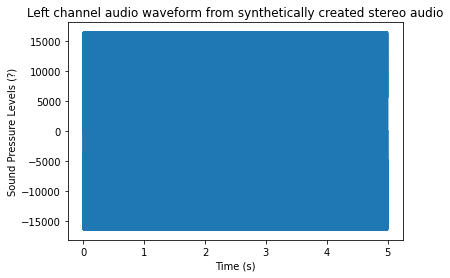

Left channel audio:


In [31]:
plt.plot(t_series,w_signal[0])
plt.xlabel('Time (s)')
plt.ylabel('Sound Pressure Levels (?)')
plt.title("Left channel audio waveform from synthetically created stereo audio")
plt.show()

print("Left channel audio:")
IPython.display.Audio(w_signal[0], rate=s_rate)

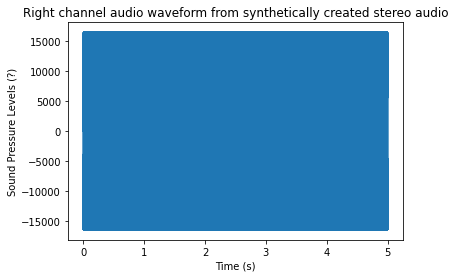

Right channel audio:


In [32]:
plt.plot(t_series,w_signal[1])
plt.xlabel('Time (s)')
plt.ylabel('Sound Pressure Levels (?)')
plt.title("Right channel audio waveform from synthetically created stereo audio")
plt.show()

print("Right channel audio:")
IPython.display.Audio(w_signal[1], rate=s_rate)

### Frequency domain broadband beamformer method

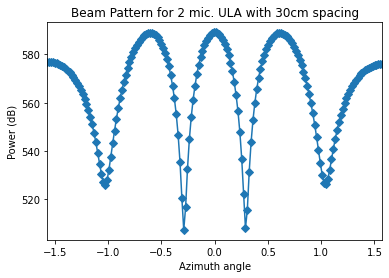

In [33]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,180)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.broadband(w_signal,s_rate,1000,steering_delay) # Performs beamforming in frequency domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()

### Time domain delay-and-sum beamforming method

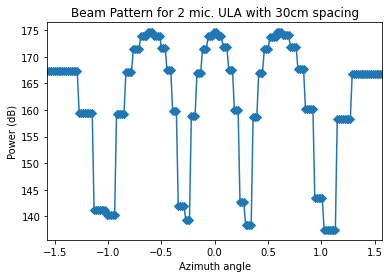

In [34]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,180)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.delay_and_sum(w_signal,s_rate,steering_delay) # Performs beamforming in time domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()

### Frequency domain Capon method

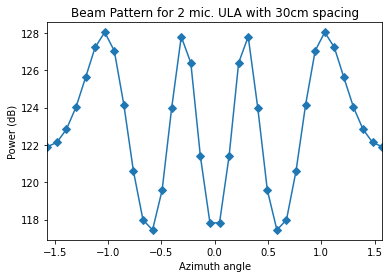

In [35]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,36)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.capon(w_signal,2000,steering_delay) # Performs beamforming in frequency domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()